# Autocorrelation function to optical spectra
In this notebook, we process autocorrelation functions to obtain optical spectra such as absorption and emission UV-visible spectra in chemistry.
The depart is directly the autocorrelation functions OR the crosscorrelation functions BUT it is not the aim of this notebook to discuss how to compute them or why compute one or the other.

The usual first thing: tell jupyter that the plots will be inline and import the most used libraries. We also define useful physical constants.

In [1]:
# %matplotlib inline
import numpy as np
import os,sys
import matplotlib.pyplot as plt

sys.path.append("../")
import TOOLBOX as TLB
import CONSTANTS as CST

## Process the Autocorrelation Function
The autocorrelation function is computed as:
\begin{equation}
<\psi(t=0)|\psi(t)>
\end{equation}
for which the $t/2$ trick can be used:
\begin{equation}
<\psi^*(t/2)|\psi(t/2)>
\end{equation}
but only in the case of __real initial wave function__.

For example, we will take as input an autocorrelation function computed with the Quantics package (with MCTDH formalism) on a meta-substituted phenylacetylene (file $\texttt{auto_abs_2}$)

In [2]:
def readAutocorrelationFunction(filename):
    """
    Read "filename" file for an autocorrelation function formatted as in Quantics (one comment line 
    and four columns: times | real part | imaginary part | absolute value)
    Return the four columns as 1-D arrays.
    """
    with open(filename,"r") as f:
        lines=f.readlines()[1:]
    lines=np.array([line.split() for line in lines]).astype(float)
    times=lines[:,0]
    realPart=lines[:,1]
    imaginaryPart=lines[:,2]
    absolutePart=lines[:,3]
    return times,realPart,imaginaryPart,absolutePart
times_abs_2,realPart_abs_2,imaginaryPart_abs_2,absolutePart_abs_2=readAutocorrelationFunction("auto_abs_2")
print(times_abs_2)
print(realPart_abs_2)

[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5  79.   79.5  80.   80.5  81.   81.5  8

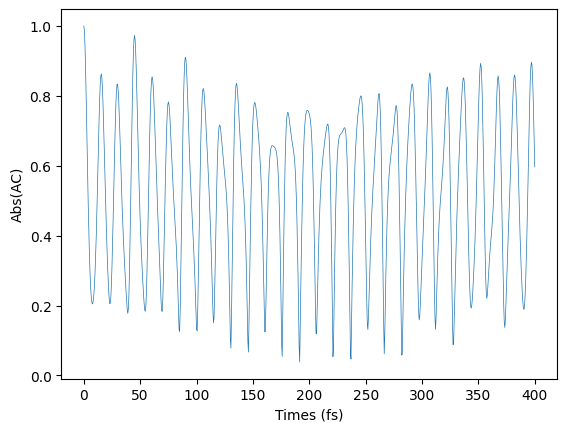

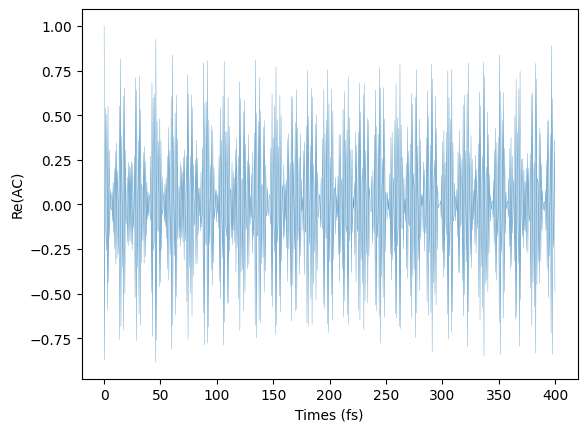

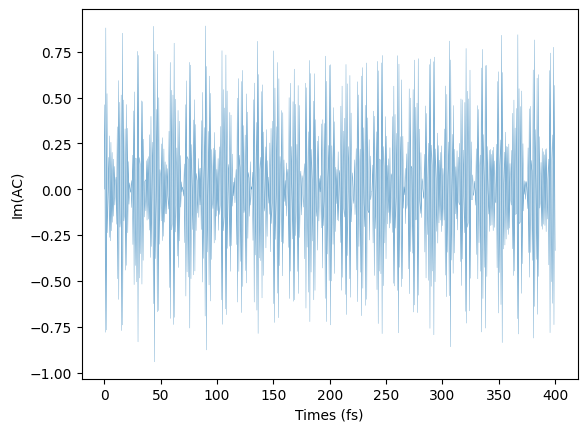

In [3]:
plt.plot(times_abs_2,absolutePart_abs_2,linewidth=0.5)
plt.xlabel("Times (fs)")
plt.ylabel("Abs(AC)")
plt.show()
plt.plot(times_abs_2,realPart_abs_2,linewidth=0.2)
plt.xlabel("Times (fs)")
plt.ylabel("Re(AC)")
plt.show()
plt.plot(times_abs_2,imaginaryPart_abs_2,linewidth=0.2)
plt.xlabel("Times (fs)")
plt.ylabel("Im(AC)")
plt.show()

Now, there is no direct information obtainable in plotting the autocorrelation function.
We can still check that a time 0, the autocorrelation function is 1 (if not, there is a problem).


## Computation of the raw spectrum 
### First attempt

The next step is thus to take the Fourier transform of this autocorrelation function to acces what we will call a raw spectrum.
\begin{equation}
\sigma(\omega)=\text{prefactor}\int_0^T \text{Re}\left[c(t)\exp(j(\omega-\omega_\text{offset})t\right] \mathrm{d}t.
\end{equation}

In a first attempt to compute this Fourier transform, we compute the integral in a very approximate discrete way:
\begin{equation}
\sigma(\omega)=\text{prefactor}\sum_i \text{Re}\left[c(t_i)\exp(j(\omega-\omega_\text{offset})t_i\right] \delta t.
\end{equation}

where the prefactor is $1/\pi$. 
Note that
- the complex argument of the exponential for the FT must be adimensioned (in the code below, conversion from fs and eV to atomic units);
- the measure of time $\delta t$ must be in atomic units.

Δt 0.5
T 400.0


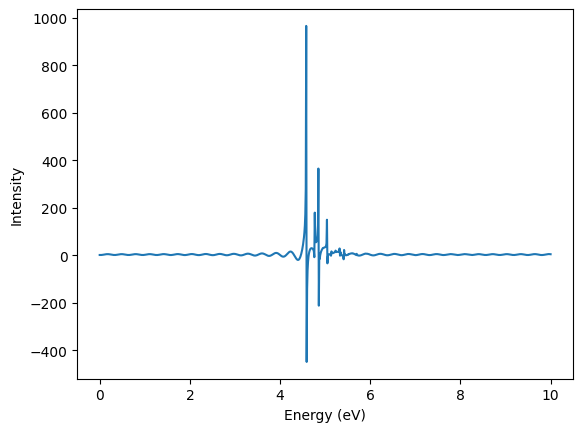

In [4]:
energies=np.linspace(0,10,1001)
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
deltat=times[1]-times[0]
T=times[-1]
omega_offset=0
print("Δt",deltat)
print("T",T)
prefac=1/np.pi
FT=[]
for i,energy in enumerate(energies):
    omega=energy
    FT.append(
        prefac*np.sum(
            (
                (realPart+1j*imaginaryPart)
                *np.exp(1j*(omega-omega_offset)*times*CST.FS_TO_AU/CST.HARTREE_TO_EV)
            ).real
            *deltat*CST.FS_TO_AU
        )
    )
FT=np.array(FT)
plt.plot(energies,FT)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.show()

# We also propose a version closer to the usual Fortran implementations, without the use of numpy for the summation
# but that is of course slower.
# to test it, uncomment next line:
test=False
if test:
    times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
    FT=[]
    for i,energy in enumerate(energies):
        omega=energy
        sum0=0
        for n,t in enumerate(times):
            sum0+=(
            (realPart[n]+1j*imaginaryPart[n])
            *np.exp(1j*(omega-omega_offset)*times[n]*CST.FS_TO_AU/CST.HARTREE_TO_EV)
            *deltat*CST.FS_TO_AU
            ).real
        FT.append(prefac*sum0)
    FT=np.array(FT)

    plt.plot(energies,FT)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Intensity")
    plt.show()

Note: for comparison with, for instance, the $\texttt{Quantics}$ built-in program that computes autocorrelation spectra ($\texttt{autospec -inter}$), one must be sure to use the same energy grid.
Indeed, as the intensities of the peaks of what resembles a stick spectrum here are highly dependent on the energy grid intervals.

### Solve the negative intensities and broadened bands problems
Now, one problem is the following: there are negative intensities.
This is due to the finite propagation in time and the approximate calculation of the spectrum with a discretization of time.

One solution is to apply a cos filter, by multiplying the FT with:
\begin{equation}
\cos^n{\left(\frac{\pi t_i}{2T}\right)}
\end{equation}
where $n=0,1,2$ but in general (and in the following) $n=1$.

Δt 0.5
T 400.0


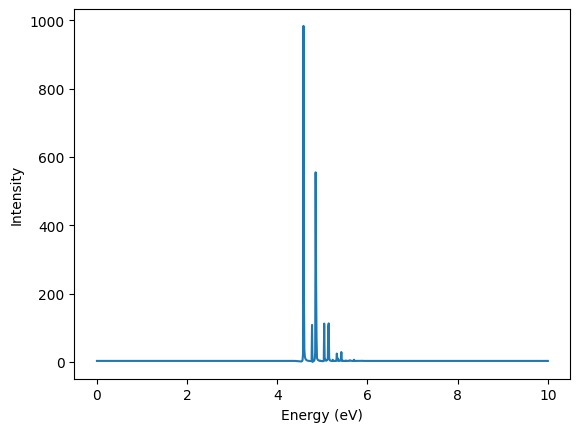

In [5]:
energies=np.linspace(0,10,1001)
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
deltat=times[1]-times[0]
T=times[-1]
omega_offset=0
n=1
print("Δt",deltat)
print("T",T)
prefac=1/np.pi
FT=[]
for i,energy in enumerate(energies):
    omega=energy
    FT.append(
        prefac*np.sum(
            (
                (realPart+1j*imaginaryPart)
                *np.exp(1j*(omega-omega_offset)*times*CST.FS_TO_AU/CST.HARTREE_TO_EV)
            ).real
            *deltat*CST.FS_TO_AU
            *np.cos((np.pi*times)/(2*T))**n
        )
    )
FT=np.array(FT)
plt.plot(energies,FT)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.show()

Now, the spectrum has no negative intensity and is almost a stick spectrum, with very small full width at half maximum (FWHM). 
To reproduce a part of the experimental broadening, one can apply a damping function with a characteristic time $\tau$:
\begin{equation}
\exp{\left(-\left(\frac{t_i}{\tau}\right)^\text{iexp}\right)}.
\end{equation}
One can also check that with the damping function, the energy grid interval is less important.

Δt 0.5
T 400.0


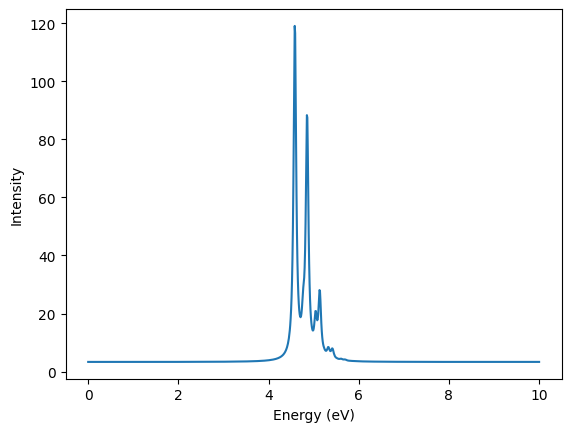

In [6]:
energies=np.linspace(0,10,1001)
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
deltat=times[1]-times[0]
T=times[-1]
omega_offset=0
n=1
tau=19
iexp=1
print("Δt",deltat)
print("T",T)
prefac=1/np.pi
FT=[]
for i,energy in enumerate(energies):
    omega=energy
    FT.append(
        prefac*np.sum(
            (
                (realPart+1j*imaginaryPart)
                *np.exp(1j*(omega-omega_offset)*times*CST.FS_TO_AU/CST.HARTREE_TO_EV)
            ).real
            *deltat*CST.FS_TO_AU
            *np.cos((np.pi*times)/(2*T))**n
            *np.exp(-(times/tau)**iexp)
        )
    )
FT=np.array(FT)
plt.plot(energies,FT)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.show()

Now let us make a function for this calculation, with flexibility on what type of spectrum is computed with the base:
\begin{equation}
\sigma(\omega)=\text{prefactor}\sum_i \text{Re}\left[c(t_i)\exp{\left(j(\omega-\omega_\text{offset}\right)t_i}\right] 
\exp{\left(-\left(\frac{t_i}{\tau}\right)^\text{iexp}\right)}
\cos^n{\left(\frac{\pi t_i}{2T}\right)}
\delta t
.
\end{equation}

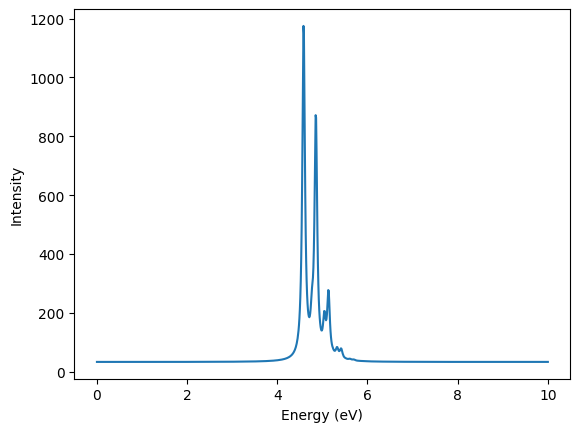

In [7]:
def autocorrelation2spectrum(times,realPart,imaginaryPart,
                             emin=0,emax=10,epoints=1001,eoffset=0,
                             tau=0,iexp=1,n=1,prefac=np.pi,
                             eunits="ev",tunits="fs"):
    """
    Computes the spectrum (Discrete Fourier Transfor) of a given complex autocorrelation function as a function of
    time "times".
    Takes as mandatory inputs:
    - times, the times for which the autocorrelation function is available (float array of dimension n)
    - realPart, the real part of the autocorrelation function (float array of dimension n)
    - imaginaryPart, the imaginary part of the aucorrelation function (float array of dimension n)
    and as optional arguments:
    - emin, emax, epoints the energy grid point wanted for the spectrum (float, float, integer, a.u. or eV)
      (default: 0, 10, 1001)
    - eoffset, a possible offset to apply to the energy grid point (float, a.u. or eV, default: 0)
    - tau, the time for which the autocorrelation must be damped (float, a.u. or fs, default: 0)
      if 0, no damping function is applied
    - iexp, the exponential exposant for the damping function (integer, default: 1)
    - n, the exposant for the cos filter (integer, default: 1)
    - prefactor, the prefactor for the discrete integration over time (float, default: pi)
    - eunits, tunits, the unit types for energy and times (string, string, default: ev and fs respectively)
    """
    if tunits=="fs":
        times=times*CST.FS_TO_AU
        tau=tau*CST.FS_TO_AU
    energies=np.linspace(emin,emax,epoints)
    if eunits=="ev":
        omegas=energies/CST.HARTREE_TO_EV
        omega_offset=eoffset/CST.HARTREE_TO_EV
    if tau==0:
        tau=1
        damp=0
    else:
        damp=1
    deltat=times[1]-times[0]
    T=times[-1]
    FT=[]
    for i,omega in enumerate(omegas):
        FT.append(
            prefac*np.sum(
                (
                    (realPart+1j*imaginaryPart)
                    *np.exp(1j*(omega-omega_offset)*times)
                ).real
                *deltat
                *np.cos((np.pi*times)/(2*T))**n
                *(np.exp(-(times/tau)**iexp))**damp
            )
        )
    FT=np.array(FT)
    return energies,FT
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
plt.plot(energies,FT)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.show()

Let us try and plot another spectrum, here an emission spectrum from a particular initial state in the electronic excited state manifold:

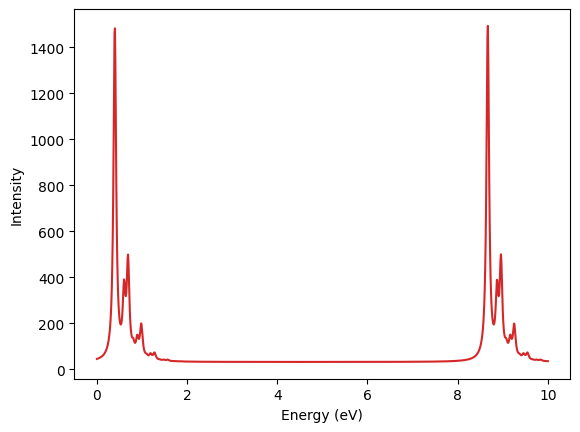

In [8]:
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_emi_2a")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
plt.plot(energies,FT,color="tab:red")
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.show()

Note that the spectrum has a duplicate in high energy. 
It is because __(TODO: complete justification)__.

Finally, we have a function that computes the spectrum from an autocorrelation function and a given energy grid.
However, it is still kind of a _raw_ spectrum in a sense that the energies for the transition are given with the reference of $E(\boldsymbol{Q}=\boldsymbol{0})=0$.
Thus, these energies are not transition energies.

## Computation of absorption and/or emission spectra
The energies for which the TF exhibits non-zero intensities are raw energies, with respect to the minimum energy as taken by $\texttt{Quantics}$.

The transition energies are as follows:
\begin{equation}
|\Delta E | = |E(\texttt{Quantics})-\text{ZPE}(\text{S}_\text{0})|
\end{equation}
for an absorption spectrum and 
\begin{equation}
|\Delta E | = |E(\texttt{Quantics})-\text{"ZPE"}(\text{S}_\text{1})|
\end{equation}
for an emission spectrum.

Note that the ZPE(S_0) is in general simply the evaluate as the zero point energy of the electronic ground state.
The ZPE(S_1) might be more difficult to obtain when multiple excited states are involved in the vibronic states of the electronic excited state manifold.

It is not directly the aim of this notebook to discuss the obtention of such reference energies, so we give them in the next block of code.
Note that such energies can be obtained using the relaxation (propagation in negative imaginary times) method in $\texttt{Quantics}$.

In [9]:
ZPES0=0.395905 # eV
ZPE2A=4.583518 # eV
ZPE2B=4.583518 # eV
ZPE3A=4.575895 # eV
ZPE3B=4.575895 # eV

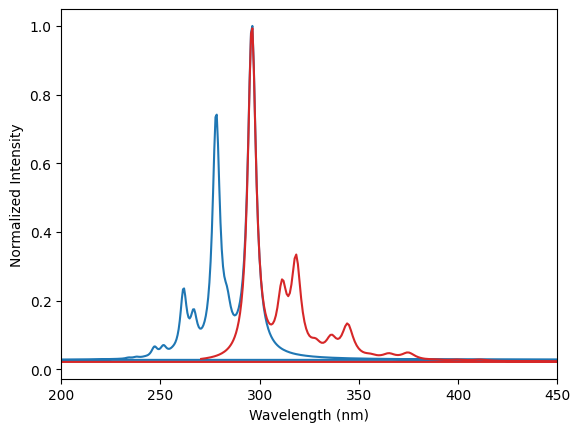

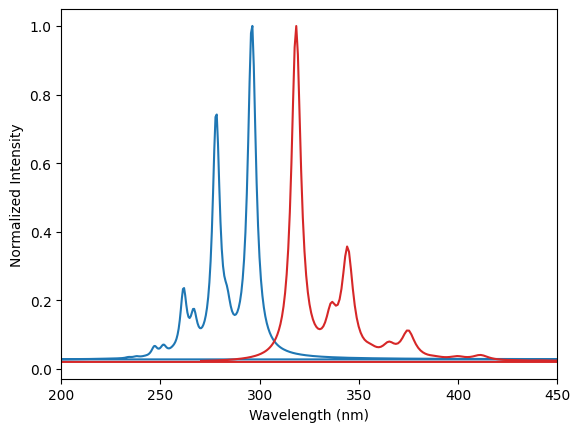

In [10]:
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
energies=energies-ZPES0
plt.plot(CST.EV_TO_NM/energies,FT/np.max(FT))
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_emi_2a")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
energies=ZPE2A-energies
plt.plot(CST.EV_TO_NM/energies,FT/np.max(FT),color="tab:red")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity")
plt.xlim(200,450)
plt.show()
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_abs_2")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
energies=energies-ZPES0
plt.plot(CST.EV_TO_NM/energies,FT/np.max(FT))
times,realPart,imaginaryPart,absolutePart=readAutocorrelationFunction("auto_emi_2b")
energies,FT=autocorrelation2spectrum(times,realPart,imaginaryPart,tau=19)
energies=ZPE2B-energies
plt.plot(CST.EV_TO_NM/energies,FT/np.max(FT),color="tab:red")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity")
plt.xlim(200,450)
plt.show()

# Supposedly OLD/TO DELETE

a0 1.0
b0 0.0
Δt 0.5
T 400.0


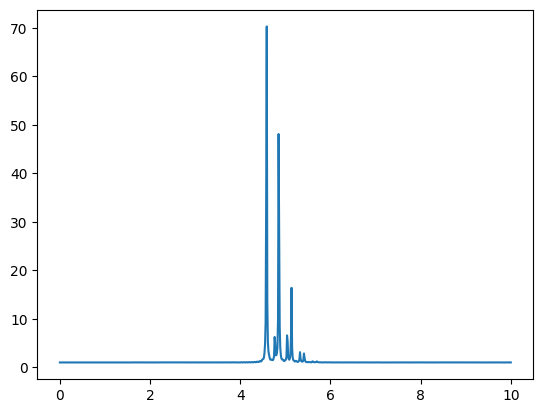

In [11]:
energies=np.linspace(0,10,801)
times_abs_2,realPart_abs_2,imaginaryPart_abs_2,absolutePart_abs_2=readAutocorrelationFunction("auto_abs_2")
deltat=times_abs_2[1]-times_abs_2[0]
T=times_abs_2[-1]
tau=100
n=1
omega_offset=0
prefac=1
iexp=1
a0=realPart_abs_2[0]
b0=imaginaryPart_abs_2[0]
print("a0",a0)
print("b0",b0)
print("Δt",deltat)
print("T",T)
FT=[]
numpy_sum=False
for i,energy in enumerate(energies):
# for i in range(epoints):
    # omega=emin+i*deltaE
    omega=energy
    # energies.append(omega)
    # FT.append(np.sum(deltat*absolutePart_abs_2*np.exp(1j*energy*times_abs_2)))
    # FT.append(np.sum((deltat*(realPart_abs_2+1j*imaginaryPart_abs_2)*np.exp(1j*energy*times_abs_2)).real)))
    # omega=energy
    if numpy_sum:
        FT.append(
            prefac*np.sum(
                (
                    (realPart_abs_2+1j*imaginaryPart_abs_2)*np.exp(1j*(omega-omega_offset)*times_abs_2*fs2au/hartree2ev)
                    # absolutePart_abs_2*np.exp(1j*omega*times_abs_2)
                )
                .real
                *np.exp(-(times_abs_2/tau)**(iexp))
                # *deltat/np.pi
                # *np.cos(np.pi*times_abs_2/(2*T))**n
                # *np.cos(np.pi*np.arange(len(energies)+1)/(2*T))**n
            )
            # *deltat/T
        )
    else:
        sum0=0.5*a0
        for n,t in enumerate(times_abs_2):
            sum0+=(
            (realPart_abs_2[n]+1j*imaginaryPart_abs_2[n])
            *np.exp(1j*(omega-omega_offset)*times_abs_2[n]*CST.FS_TO_AU/CST.HARTREE_TO_EV)
            ).real*np.exp(-(times_abs_2[n]/tau)**iexp)
        FT.append(sum0)
# energies=np.array(energies)
FT=np.array(FT)

plt.plot(energies,FT)
# plt.scatter(energies[np.argmax(FT)],np.max(FT),marker="+",c='r')
plt.show()

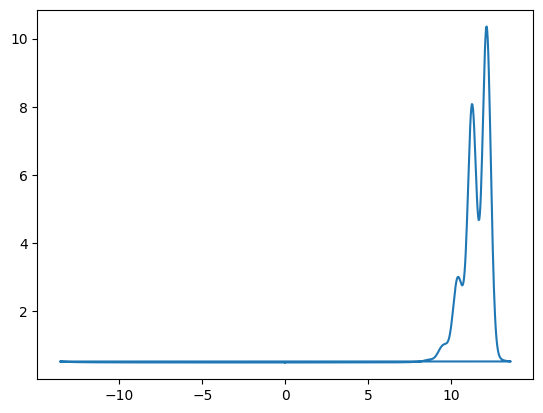

801


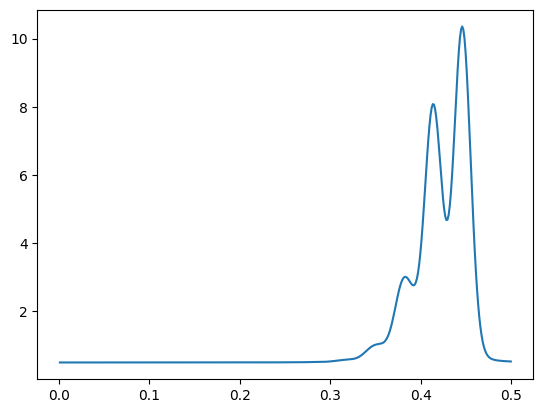

(801,)
(801,)
(801,)


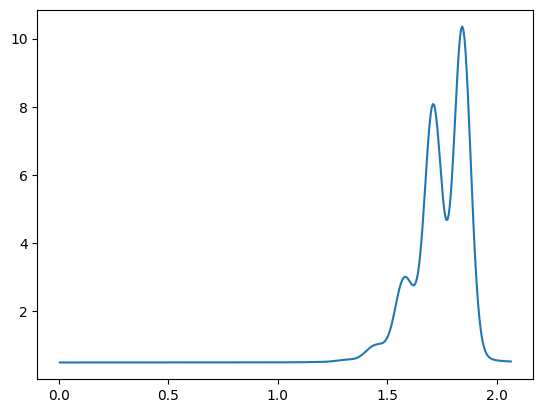

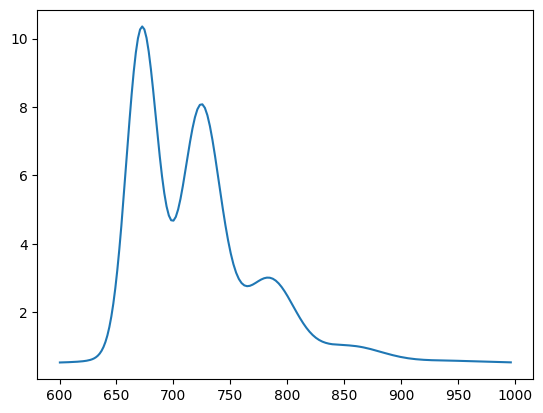

In [12]:
times_abs_2,realPart_abs_2,imaginaryPart_abs_2,absolutePart_abs_2=readAutocorrelationFunction("auto_abs_2")
t = np.copy(times_abs_2)
t = t*CST.FS_TO_AU/CST.HARTREE_TO_EV
# sp = np.fft.fft((realPart_abs_2+1j*imaginaryPart_abs_2))
sp = np.fft.fft((realPart_abs_2+1j*imaginaryPart_abs_2)*np.exp(-(times_abs_2/tau))*np.cos(np.pi*times_abs_2/(2*T))**n)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq*CST.HARTREE_TO_EV, sp.real)
plt.show()
print(t.shape[-1])
where=(freq)>0
plt.plot(freq[where], sp.real[where])
plt.show()
print(freq.shape)
print(energies.shape)
print(sp.real.shape)
plt.plot((10**15)*freq[where]*CST.PLANCK_CONSTANT/CST.EV_TO_JOULE, sp.real[where])
plt.show()
where=(freq)>0.3
plt.plot(CST.EV_TO_NM/((10**15)*freq[where]*CST.PLANCK_CONSTANT/CST.EV_TO_JOULE), sp.real[where])
plt.show()
# plt.plot(energies,sp.real)
# plt.show()
# plt.plot(1239/energies[energies>2],sp.real[energies>2])

dumped with an exponential $\exp((-t/\tau)^\text{iexp})$